In [36]:
from __future__ import print_function
import pandas as pd
import numpy as np
import re
import os
import pickle
import sys
import os.path
from datetime import datetime, date, time 
from dateutil.parser import parse
from time import strftime
import pyarrow
import requests
import json
import qwikidata
import qwikidata.sparql
import matplotlib.pyplot as plt

pd.options.display.max_rows = 1000

#Create place to save diagrams
image_dir = './images/'
if not os.path.exists(image_dir):
    os.mkdir(image_dir)

In [37]:
DATA_DIR  = '/Users/award40/Desktop/covidify-output/data/' + str(datetime.date(datetime.now()))
FILE  = 'agg_data_' + str(datetime.date(datetime.now())) + '.parquet.gzip'

print('reading:', os.path.join(DATA_DIR, FILE))
df = pd.read_parquet(os.path.join(DATA_DIR, FILE))

for col in ['confirmed', 'deaths', 'recovered']:
    df[col] = df[col].replace('', 0).astype(int)

reading: /Users/award40/Desktop/covidify-output/data/2020-04-04/agg_data_2020-04-04.parquet.gzip


In [39]:
def get_top_countries(data):
    tmp_df = data.copy()
    tmp_df = tmp_df[tmp_df.file_date == df.file_date.max()]
    return tmp_df.groupby(['country']).agg({'confirmed': 'sum'}).sort_values('confirmed', ascending=False).head(10).index 
        
top_df = get_top_countries(df)    

In [40]:
top_df

Index(['America', 'Italy', 'Spain', 'Germany', 'China', 'France', 'Iran',
       'United Kingdom', 'Turkey', 'Switzerland'],
      dtype='object', name='country')

In [41]:
#filter dataframe
COUNTRIES = ['America', 'China', 'France', 'Ireland', 'Italy', 'South Korea']

df = df[df.country.isin(COUNTRIES)]

In [42]:
df = df.sort_values(['country', 'file_date'])

In [43]:
# df

In [44]:
# COUNTRIES = ['America', 'China', 'France', 'Ireland', 'Italy', 'South Korea']

def get_day_counts(d, country):
    '''
    For each country, get the days of the spread since 500
    cases
    '''
    data = d.copy()
    result_df = pd.DataFrame([])
    result_df = data.groupby(['file_date']).agg({'confirmed': 'sum',
                                                'recovered': 'sum',
                                                'deaths': 'sum'})
    result_df['date'] = data['file_date'].unique()
    result_df['country'] = country
        
    result_df = result_df[result_df.confirmed >= 500]
    result_df.insert(loc=0, column='day', value=np.arange(len(result_df)))
    return result_df

df_list = []

for country in sorted(COUNTRIES):
    print(country)
    df_list.append(get_day_counts(df[df.country == country], country))
    
new_df = pd.concat(df_list, axis=0, ignore_index=True)
# new_df = new_df.sort_values(['country', 'day'])

America
China
France
Ireland
Italy
South Korea


In [45]:
# new_df

In [46]:
# def get_country_cases(col, df, country):
#     values = []
    
#     for date in df.file_date.unique():
#         tmp_df = df[df.file_date == date]
#         try:
#             values.append(tmp_df[tmp_df.country == country].confirmed.sum())
#         except:
#             values.append(0)
#     return values

# #Check if country not in filter dataframe
# for country in COUNTRIES:
#     if country not in df.country.values:
#         print(country, 'not in list. Please check spelling')
#     else:
#         test_df[country.lower() + '_confirmed'] = get_country_cases('confirmed', df, country)

In [47]:

# def fix_data(tmp_df):


# #Check if country not in filter dataframe
# for country in COUNTRIES:
#     if country not in df.country.values:
#         print(country, 'not in list. Please check spelling')
#     else:
#         test_df[country.lower() + '_confirmed'] = get_country_cases('confirmed', df, country)

In [48]:
# new_df

## Plotting

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#set ggplot style
plt.style.use('ggplot')

In [50]:
# new_df

In [51]:
col_list = [x for x in new_df.columns if x != 'date']

AttributeError: 'AxesSubplot' object has no attribute 'set_color_cycle'

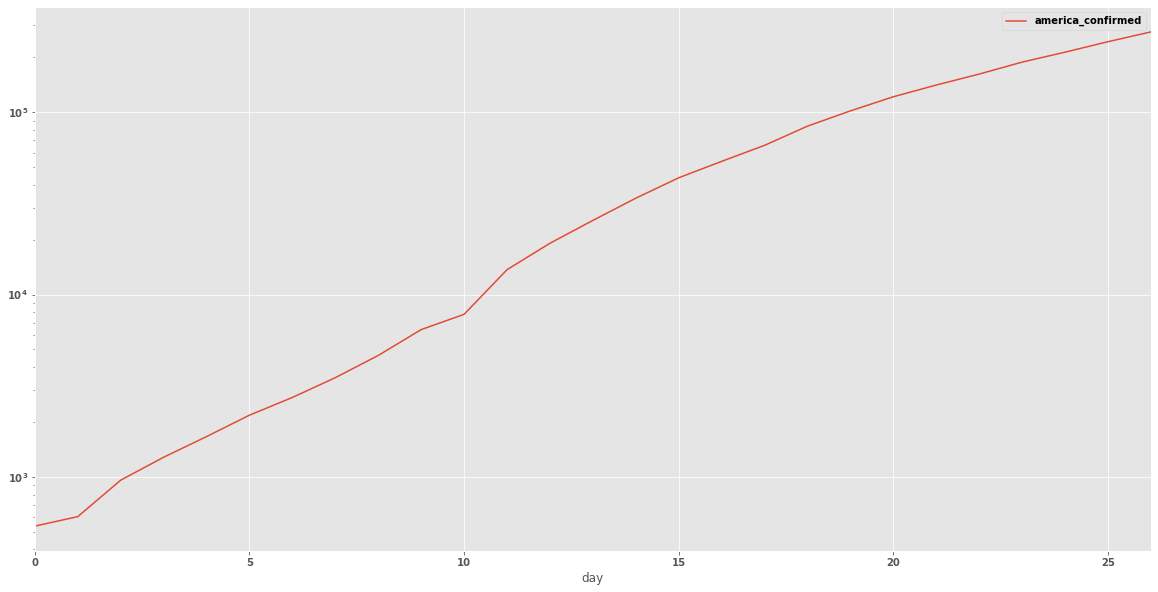

In [52]:
def log_plot(tmp, col):
    fig, ax = plt.subplots(figsize=(20,10))
    for country in tmp.country.unique():
        new_col = country.lower() + '_' + col
        
        tmp[country.lower() + '_' + col] = tmp[[col]]
        tmp.rename(columns={col: new_col})
        tmp[tmp.country == country].groupby(['day'])[[new_col]].sum().plot(ax=ax)
        ax.set_yscale('log', basey=10)
        ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    fig = ax.get_figure()
    fig.savefig(os.path.join(image_dir, create_save_file(col, 'log')))

for col in ['confirmed', 'recovered', 'deaths']:
    log_plot(new_df, col)